In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
dt = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()
lr = LogisticRegression(random_state=42, max_iter=1000)

param_grid_dt = {
   'classifier__max_depth': [3, 5, 10, None],
   'classifier__min_samples_split': [2, 5, 10],
   'classifier__min_samples_leaf': [1, 2, 4],
   'feature_selection__k': [5, 10, 15]
}

param_grid_knn = {
   'classifier__n_neighbors': [3, 5, 7, 9],
   'classifier__weights': ['uniform', 'distance'],
   'classifier__metric': ['euclidean', 'manhattan'],
   'feature_selection__k': [5, 10, 15]
}

param_grid_lr = {
   'classifier__C': [0.01, 0.1, 1, 10, 100],
   'classifier__penalty': ['l1', 'l2'],
   'classifier__solver': ['liblinear'],
   'feature_selection__k': [5, 10, 15]
}

classifiers_to_tune = [
   (dt, param_grid_dt, 'Decision Tree'),
   (knn, param_grid_knn, 'k-NN'),
   (lr, param_grid_lr, 'Logistic Regression')
]

In [3]:
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

In [4]:
def load_hr_attrition():
    """Load IBM HR Attrition dataset"""
    try:
        data = pd.read_csv("data/WA_Fn-UseC_-HR-Employee-Attrition.csv")
    except FileNotFoundError:
        print("HR Attrition dataset not found. Please place 'WA_Fn-UseC_-HR-Employee-Attrition.csv' inside a 'data/' folder.")
        return None, None, None, None, "HR Attrition (Failed)"

    # Target: Attrition = Yes (1), No (0)
    data['Attrition'] = (data['Attrition'] == 'Yes').astype(int)

    # Drop ID-like column
    X = data.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = data['Attrition']

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("IBM HR Attrition dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

In [5]:
def load_banknote():
    """Load Banknote Authentication dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        data = pd.read_csv(url, header=None)
    except Exception as e:
        print(f"Error loading Banknote dataset: {e}")
        return None, None, None, None, "Banknote (Failed)"

    # According to UCI: variance, skewness, curtosis, entropy, class (0=authentic, 1=fake)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("Banknote Authentication dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Banknote Authentication"

In [6]:
def load_qsar_biodegradation():
    """Load QSAR Biodegradation dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv"

    try:
        data = pd.read_csv(url, sep=';', header=None)
    except Exception as e:
        print(f"Error loading QSAR dataset: {e}")
        return None, None, None, None, "QSAR (Failed)"

    # Last column is target (RB = ready biodegradable, NRB = not)
    X = data.iloc[:, :-1]
    y = (data.iloc[:, -1] == 'RB').astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("QSAR Biodegradation dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "QSAR Biodegradation"

In [7]:
def run_manual_grid_search(X_train, y_train, dataset_name):
   """Run manual grid search and return best estimators"""
   print(f"\n{'='*60}")
   print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
   print(f"{'='*60}")

   best_estimators = {}
   cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

   # Adjust parameter grids based on dataset size
   n_features = X_train.shape[1]

   for classifier_instance, param_grid, name in classifiers_to_tune:
       print(f"--- Manual Grid Search for {name} ---")
       best_score = -1
       best_params = None

       adjusted_param_grid = param_grid.copy()
       max_k = min(n_features, max(adjusted_param_grid['feature_selection__k']))
       adjusted_param_grid['feature_selection__k'] = [k for k in adjusted_param_grid['feature_selection__k'] if k <= max_k]

       param_names = list(adjusted_param_grid.keys())
       param_values = list(adjusted_param_grid.values())

       print(f"Testing {np.prod([len(v) for v in param_values])} parameter combinations...")

       for param_combination in itertools.product(*param_values):
           current_params = dict(zip(param_names, param_combination))

           cv_scores = []

           for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
               X_train_fold = X_train.iloc[train_idx]
               X_val_fold = X_train.iloc[val_idx]
               y_train_fold = y_train.iloc[train_idx]
               y_val_fold = y_train.iloc[val_idx]

               pipeline = Pipeline(steps=[
                   ('scaler', StandardScaler()),
                   ('feature_selection', SelectKBest(f_classif)),
                   ('classifier', classifier_instance.__class__(**classifier_instance.get_params()))
               ])

               pipeline.set_params(**current_params)

               pipeline.fit(X_train_fold, y_train_fold)

               y_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]

               fold_auc = roc_auc_score(y_val_fold, y_pred_proba)
               cv_scores.append(fold_auc)

           mean_cv_score = np.mean(cv_scores)

           if mean_cv_score > best_score:
               best_score = mean_cv_score
               best_params = current_params
               print(f"New best for {name}: {current_params} -> AUC: {mean_cv_score:.4f}")

       print("-" * 90)
       print(f"Best parameters for {name}: {best_params}")
       print(f"Best cross-validation AUC: {best_score:.4f}")

       final_pipeline = Pipeline(steps=[
           ('scaler', StandardScaler()),
           ('feature_selection', SelectKBest(f_classif)),
           ('classifier', classifier_instance)
       ])

       final_pipeline.set_params(**best_params)

       final_pipeline.fit(X_train, y_train)

       best_estimators[name] = final_pipeline

   return best_estimators

In [8]:
def run_builtin_grid_search(X_train, y_train, dataset_name):
   """Run built-in grid search and return best estimators"""
   print(f"\n{'='*60}")
   print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
   print(f"{'='*60}")

   results_builtin = {}

   # Adjust parameter grids based on dataset size
   n_features = X_train.shape[1]

   for classifier_instance, param_grid, name in classifiers_to_tune:
       print(f"\n--- GridSearchCV for {name} ---")

       adjusted_param_grid = param_grid.copy()
       max_k = min(n_features, max(adjusted_param_grid['feature_selection__k']))
       adjusted_param_grid['feature_selection__k'] = [k for k in adjusted_param_grid['feature_selection__k'] if k <= max_k]

       pipeline = Pipeline(steps=[
           ('scaler', StandardScaler()),
           ('feature_selection', SelectKBest(f_classif)),
           ('classifier', classifier_instance)
       ])

       cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

       grid_search = GridSearchCV(
           estimator=pipeline,
           param_grid=adjusted_param_grid,
           cv=cv_splitter,
           scoring='roc_auc',
           n_jobs=-1,
           verbose=1
       )

       print(f"Fitting GridSearchCV for {name}...")
       grid_search.fit(X_train, y_train)

       # Save results
       results_builtin[name] = {
           'best_estimator': grid_search.best_estimator_,
           'best_score (CV)': grid_search.best_score_,
           'best_params': grid_search.best_params_
       }
       print(f"Best params for {name}: {results_builtin[name]['best_params']}")
       print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

   return results_builtin

In [9]:
def evaluate_models(X_test, y_test, best_estimators, dataset_name, method_name="Manual"):
    """Evaluate models and create visualizations"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # Individual model evaluation
    print(f"\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Voting Classifier
    print(f"\n--- {method_name} Voting Classifier ---")

    if method_name == "Manual":
        # Manual voting implementation
        y_pred_votes = []
        y_pred_proba_avg = []

        for i in range(len(X_test)):
            votes = []
            probas = []

            for name, model in best_estimators.items():
                pred = model.predict(X_test.iloc[[i]])[0]
                proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                votes.append(pred)
                probas.append(proba)

            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)

            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)

        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)

    else:  # Built-in
        # Create VotingClassifier
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)  # Note: This assumes X_train, y_train are in scope

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Compute voting metrics
    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Visualizations
    # ROC Curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    # Add voting classifier to ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix for Voting Classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return y_pred_votes, y_pred_proba_avg

In [10]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(X_test, y_test, manual_estimators, actual_name, "Manual")

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator']
                         for name, results in builtin_results.items()}
    builtin_votes, builtin_proba = evaluate_models(X_test, y_test, builtin_estimators, actual_name, "Built-in")

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)


################################################################################
PROCESSING DATASET: WINE QUALITY
################################################################################
Wine Quality dataset loaded and preprocessed successfully.
Training set shape: (1119, 11)
Testing set shape: (480, 11)
------------------------------

RUNNING MANUAL GRID SEARCH FOR WINE QUALITY
--- Manual Grid Search for Decision Tree ---
Testing 72 parameter combinations...
New best for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'feature_selection__k': 5} -> AUC: 0.7554
New best for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'feature_selection__k': 10} -> AUC: 0.7566
New best for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'feature_selection__k': 5} -> AUC: 0.7796
New best for Dec

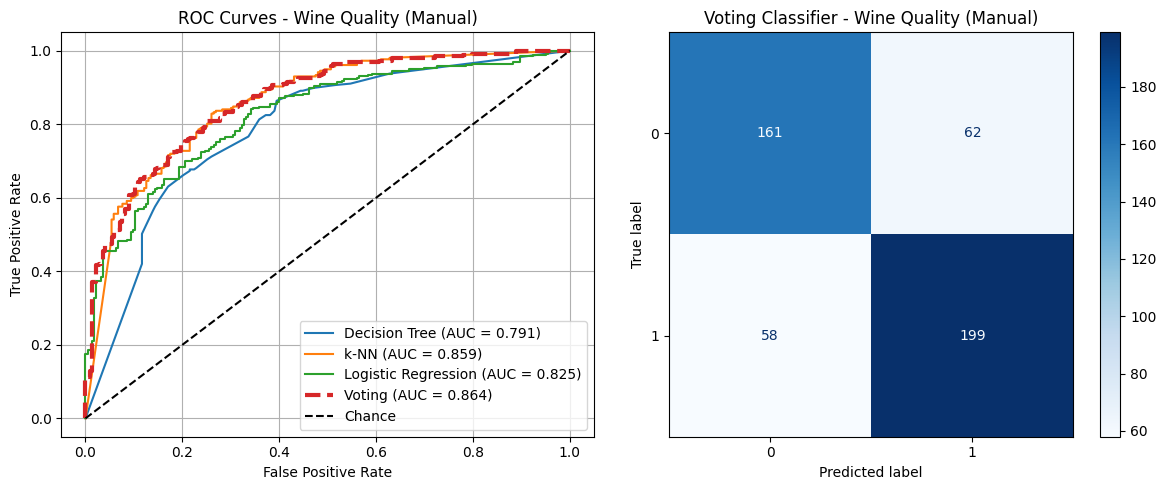


RUNNING BUILT-IN GRID SEARCH FOR WINE QUALITY

--- GridSearchCV for Decision Tree ---
Fitting GridSearchCV for Decision Tree...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params for Decision Tree: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'feature_selection__k': 5}
Best CV score: 0.7850

--- GridSearchCV for k-NN ---
Fitting GridSearchCV for k-NN...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params for k-NN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 7, 'classifier__weights': 'distance', 'feature_selection__k': 5}
Best CV score: 0.8667

--- GridSearchCV for Logistic Regression ---
Fitting GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params for Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'feature_selection__k': 10}
Best CV score: 0.8049



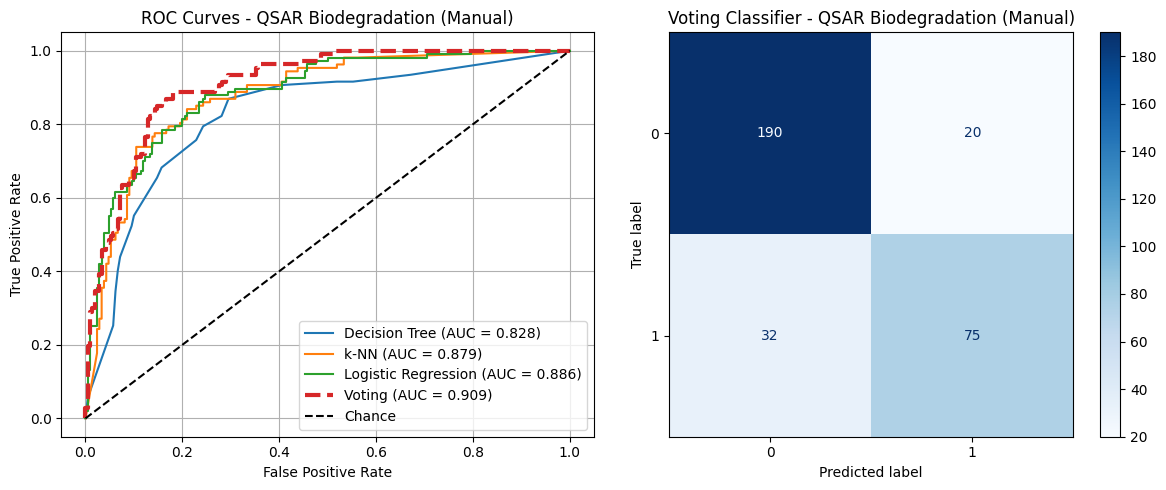


RUNNING BUILT-IN GRID SEARCH FOR QSAR BIODEGRADATION

--- GridSearchCV for Decision Tree ---
Fitting GridSearchCV for Decision Tree...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best params for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'feature_selection__k': 10}
Best CV score: 0.8400

--- GridSearchCV for k-NN ---
Fitting GridSearchCV for k-NN...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params for k-NN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'feature_selection__k': 15}
Best CV score: 0.8874

--- GridSearchCV for Logistic Regression ---
Fitting GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params for Logistic Regression: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'feature_selection__k': 15}
Best CV score

In [11]:
# --- Run Pipeline for All Datasets ---
datasets = [
    (load_wine_quality, "Wine Quality"),
    (load_hr_attrition, "HR Attrition"),
    (load_banknote, "Banknote Authentication"),
    (load_qsar_biodegradation, "QSAR Biodegradation")
]

# Run for each dataset
for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)